# Simple lane line detection project



Adding necessary inputs

In [351]:
# import the necessary packages
import os
import re
import cv2
import numpy as np
from tqdm import tqdm_notebook
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import kagglehub # for downloading video data


Adding video from dashboard camera.

In [352]:
# Download latest version
video_path = kagglehub.dataset_download("dpamgautam/video-file-for-lane-detection-project")
video_path = video_path + '\\test_video.mp4'
print("Path to dataset files:", video_path)

Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\dpamgautam\video-file-for-lane-detection-project\versions\1\test_video.mp4


In [353]:
def extract_frames_from_video(video_path, output_folder, num_frames):
    # Folder creation
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Opening mp4 video
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("Error while opening video file")
        return
    
    # get FPS from video
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Couter 
    frame_count = 0
    
    # Geting the frames
    while frame_count < num_frames:
        ret, frame = cap.read()
        
        if not ret:
            print("Can't receive frame (%d)." % frame_count)
            break
        
        # Save frame into file
        frame_filename = os.path.join(output_folder, f"frame_{frame_count + 1}.jpg")
        cv2.imwrite(frame_filename, frame)
        
        frame_count += 1
    
    # Closing object VideoCapture
    cap.release()
    print(f"{frame_count} of {num_frames} frames have been saved to {output_folder}")

# Output frames folder
output_folder = 'frames_from_video'

# number of first N frames to cut from video 
num_frames = 1000 

# custom function call
extract_frames_from_video(video_path, output_folder, num_frames)


1000 of 1000 frames have been saved to frames_from_video


In [354]:
# get file names of frames
col_frames = os.listdir('frames_from_video/')
col_frames.sort(key=lambda f: int(re.sub('\D', '', f)))

# load frames
col_images=[]
for i in tqdm(col_frames):
    img = cv2.imread('frames_from_video/'+i)
    col_images.append(img)

  0%|          | 0/1000 [00:00<?, ?it/s]

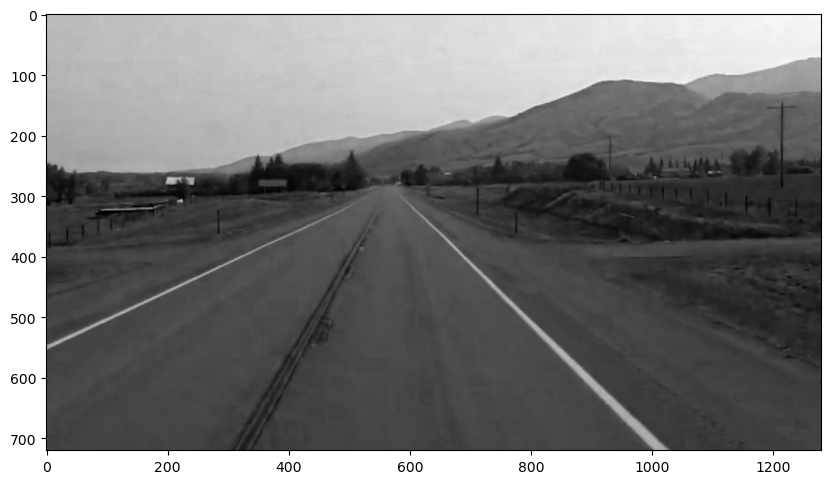

In [355]:
# specify frame index to 
idx = 10

# plot frame
plt.figure(figsize=(10,10))
plt.imshow(col_images[idx][:,:,0], cmap= "gray")
plt.show()

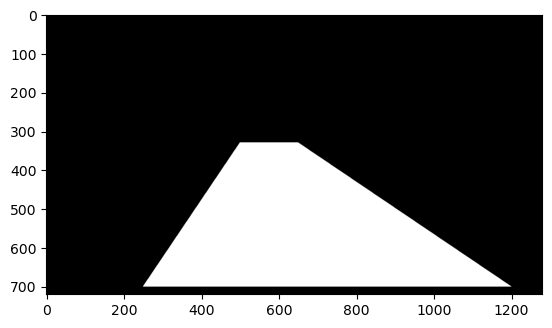

In [356]:
# create a zero array
stencil = np.zeros_like(col_images[idx][:,:,0])

# specify coordinates of the polygon
polygon = np.array([[250,700], [500,330], [650,330], [1200,700]])

# fill polygon with ones
cv2.fillConvexPoly(stencil, polygon, 1)

plt.imshow(stencil, cmap= "gray")
plt.show()

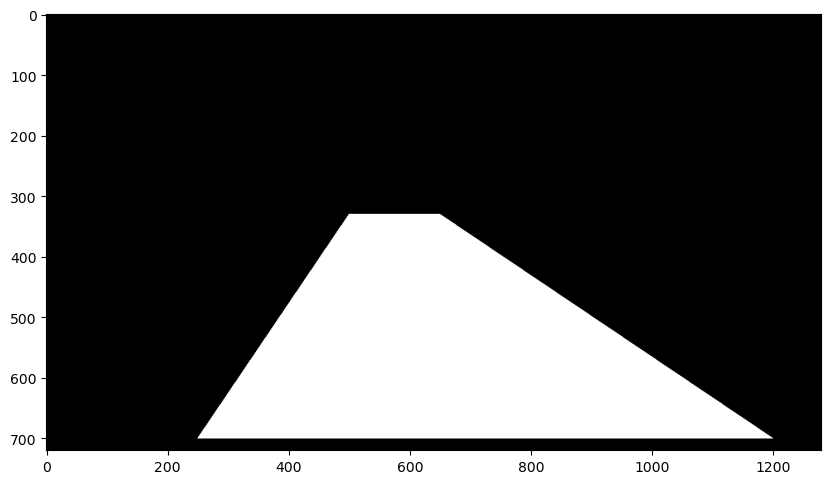

In [357]:
# plot polygon
plt.figure(figsize=(10,10))
plt.imshow(stencil, cmap= "gray")
plt.show()

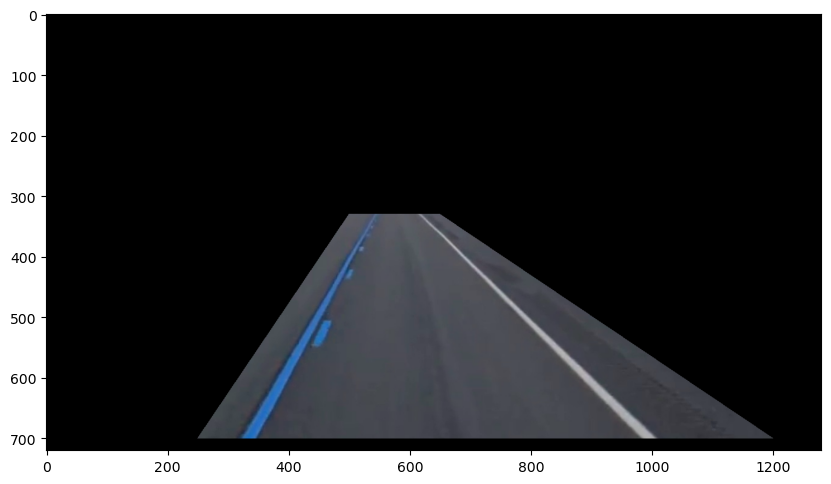

In [358]:
# apply polygon as a mask on the frame
img = cv2.bitwise_and(col_images[idx][:,:,:], col_images[idx][:,:,:], mask=stencil)

# plot masked frame
plt.figure(figsize=(10,10))
plt.imshow(img, cmap= "gray")
plt.show()

(720, 1280, 3)


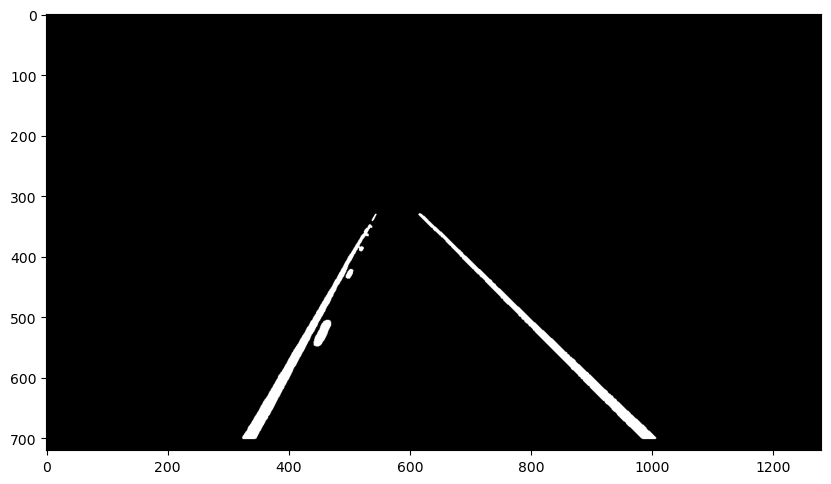

In [359]:
# Function to highlight orange and white lines
def highlight_orange_and_white_lines(img_input):
    # Convert image to HSV color space
    hsv = cv2.cvtColor(img_input, cv2.COLOR_BGR2HSV)
    
    # Orange color range in HSV
    lower_orange = np.array([10, 30, 130])
    upper_orange = np.array([50, 250, 220])
    
    # White color range in HSV
    lower_white = np.array([0, 0, 120])
    upper_white = np.array([180, 50, 255])
    
    # Create masks for orange and white
    mask_orange = cv2.inRange(hsv, lower_orange, upper_orange)
    mask_white = cv2.inRange(hsv, lower_white, upper_white)
    
    # Combine both masks
    mask_combined = cv2.bitwise_or(mask_orange, mask_white)
    
    # Apply mask to image
    result = cv2.bitwise_and(img_input, img_input, mask=mask_combined)
    
    # Convert to grayscale if the image is color
    gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY) if len(result.shape) == 3 else result
    
    # Apply Gaussian blur and thresholding
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    ret, thresh = cv2.threshold(blurred, 30, 255, cv2.THRESH_BINARY)
    
    return thresh

# Example usage
img_test = col_images[idx]
print(img_test.shape)

# Convert the image to RGB for display
img_rgb = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

# Call the function to detect orange and white lines
thresh = highlight_orange_and_white_lines(img)

# Show the result
plt.figure(figsize=(10, 10))
plt.imshow(thresh, cmap="gray")
plt.show()



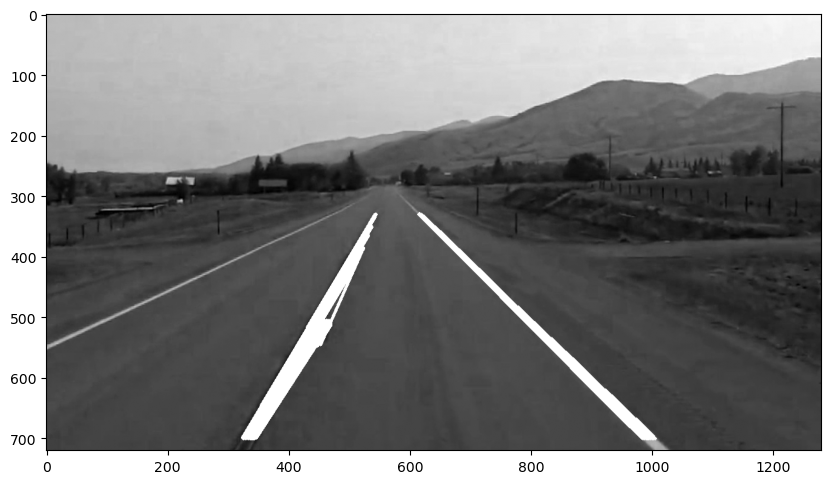

In [360]:
lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 30, maxLineGap=200)

# create a copy of the original frame
dmy = col_images[idx][:,:,0].copy()

# draw Hough lines
for line in lines:
  x1, y1, x2, y2 = line[0]
  cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 3)

# plot frame
plt.figure(figsize=(10,10))
plt.imshow(dmy, cmap= "gray")
plt.show()

In [361]:
cnt = 0

for img in tqdm(col_images):
  
  # apply frame mask
  # masked = cv2.bitwise_and(img[:,:,0], img[:,:,0], mask=stencil)
  
  # apply image thresholding
  # ret, thresh = cv2.threshold(masked, 130, 145, cv2.THRESH_BINARY)
  
  # apply polygon as a mask on the frame
  masked = cv2.bitwise_and(img[:,:,:], img[:,:,:], mask=stencil)

  thresh = highlight_orange_and_white_lines(masked)

  # apply Hough Line Transformation
  lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 30, maxLineGap=200)
  dmy = img.copy()
  
  # Plot detected lines
  try:
    for line in lines:
      x1, y1, x2, y2 = line[0]
      cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 3)
  
    cv2.imwrite('detected/'+str(cnt)+'.png',dmy)
  
  except TypeError: 
    cv2.imwrite('detected/'+str(cnt)+'.png',img)

  cnt+= 1

  0%|          | 0/1000 [00:00<?, ?it/s]

In [366]:
# input frames path
pathIn= 'detected/'

# output path to save the video
pathOut = 'roads_v2.mp4'

# specify frames per second
fps = 30.0

In [367]:
from os.path import isfile, join

# get file names of the frames
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
files.sort(key=lambda f: int(re.sub('\D', '', f)))

In [364]:
frame_list = []

for i in tqdm(range(len(files))):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_list.append(img)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [365]:
# write the video
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for i in range(len(frame_list)):
    # writing to a image array
    out.write(frame_list[i])

out.release()